In [1]:
import sys
sys.path.insert(1, '/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import getdist
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
import numpy as np
import scipy
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
from jax.scipy.stats import uniform
import chaospy
from nfmc_jax.sinf.RQspline import kde
import torch
from scipy.special import loggamma
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)

### Misc functions

In [2]:
def t2a(tens): return tens.numpy().astype(np.float64)
def a2t(arr): return torch.from_numpy(arr.astype(np.float32))
def sample_qmodel_1d(qmodel,N,Z=1,dim=0):
    samples,qvalues = qmodel.sample(N,device='cpu')
    #sample n samples
    samples = samples[:,dim]
    #use the sinf kde implementation - should use Scott's rule with no bwfactor
    kdeq = kde(samples)
    def fkde(x):
        return t2a(kdeq(a2t(x)))*Z
    return fkde,samples

def sample_gaussian(N,mean,cov,seed=seed):
    g1 = n_mvn.rvs(mean=mean,cov=cov,size=N,random_state=seed)
    return np.atleast_2d(g1)

def double_sample_gaussian(N,w1,mean1,mean2,cov1,cov2,seed=seed):
    g1 = n_mvn.rvs(mean=mean1,cov=cov1,size=int(N*w1),random_state=seed)
    g2 = n_mvn.rvs(mean=mean2,cov=cov2,size=int(N*(1-w1)),random_state=seed)
    return np.concatenate([np.atleast_2d(g1),np.atleast_2d(g2)])

def sample_truth_1d(N,mean,cov,dim=0):
    mean,cov = np.asarray(mean),np.asarray(cov)
    samples = sample_gaussian(N,mean,cov)
    samples = samples[:,dim]
    kdeq = kde(a2t(samples))
    def fkde(x):
        return t2a(kdeq(a2t(x)))
    return fkde,samples

def double_sample_truth_1d(N,w1,mean1,mean2,cov1,cov2,dim=0):
    mean1,mean2,cov1,cov2 = np.asarray(mean1),np.asarray(mean2),np.asarray(cov1),np.asarray(cov2)
    samples = double_sample_gaussian(N,w1,mean1,mean2,cov1,cov2)
    samples = samples[:,dim]
    kdeq = kde(a2t(samples))
    def fkde(x):
        return t2a(kdeq(a2t(x)))
    return fkde,samples

def log_1d_normal(x,mu=0,sigma=1,n=1):
    return -1/2*( n*np.log(2*np.pi) + sigma + ((x-mu)/sigma)**2 )

def plot_1d_uncorrelated(trace,low,high,n,n_1d=1000,beta_idx=None,sig_scale=1/10):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    mu_truth,sigma_truth = jnp.zeros(n),sig_scale*jnp.ones(n)
    x1_1d = np.linspace(low,high,n_1d)
    if(beta_idx is None): beta_idx=qnums.max()
    truths=[]
    logZpq = trace['logZ'][0]['q{0}_pq_w'.format(beta_idx)]
    for d in range(n):
        plt.plot(x1_1d,
                       sample_qmodel_1d(qmodels[0]['q{0}_w'.format(beta_idx)],n_1d,Z=1,dim=d)[0](x1_1d),
                       ls='-',marker=' ',lw=1,
                       c='C{0}'.format(d),
                      )
        plt.plot(x1_1d,
               sample_qmodel_1d(qmodels[0]['q{0}_uw'.format(beta_idx)],n_1d,Z=1,dim=d)[0](x1_1d),
               ls=':',marker=' ',lw=1,
               c='C{0}'.format(d),
              )
        truths.append(sample_truth_1d(n_1d,mu_truth,sigma_truth,dim=d)[0](x1_1d))
   
    plt.plot(x1_1d,np.mean(np.array(truths),axis=0),c='k',zorder=-1) # just to suppress noise in kde since all the same in uncorrelated...
#     plt.plot(samples[0]['q{0}'.format(beta_idx)],np.exp(logp[0]['q{0}'.format(beta_idx)]),ls=' ',marker='.')
    plt.axvline(0,ls='--',c='k')
    plt.show()
    return 0

def plot_1d_double(trace,low,high,n,n_1d=1000,beta_idx=None,w1=0.3,mu1_diag=0.625, mu2_diag=-0.325,sig_scale=1/10,sig_scale_12=1/2):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    sigma_truth = sig_scale*jnp.ones(n)
    mu1_truth,mu2_truth = mu1_diag*jnp.ones(n),mu2_diag*jnp.ones(n)
    x1_1d = np.linspace(low,high,n_1d)
    if(beta_idx is None): beta_idx=qnums.max()
    truths=[]
    logZpq = trace['logZ'][0]['q{0}_pq_w'.format(beta_idx)]
    for d in range(n):
        plt.plot(x1_1d,
                       sample_qmodel_1d(qmodels[0]['q{0}_w'.format(beta_idx)],n_1d,Z=1,dim=d)[0](x1_1d),
                       ls='-',marker=' ',lw=1,
                       c='C{0}'.format(d),
                      )
        plt.plot(x1_1d,
               sample_qmodel_1d(qmodels[0]['q{0}_uw'.format(beta_idx)],n_1d,Z=1,dim=d)[0](x1_1d),
               ls=':',marker=' ',lw=1,
               c='C{0}'.format(d),
              )
        truths.append(double_sample_truth_1d(n_1d,w1,mu1_truth,mu2_truth,sigma_truth*sig_scale_12,sigma_truth,dim=d)[0](x1_1d))
   
    plt.plot(x1_1d,np.mean(np.array(truths),axis=0),c='k',zorder=-1)
    plt.axvline(mu1_diag,ls='--',c='k')
    plt.axvline(mu2_diag,ls='--',c='k')
    plt.show()
    return 0



In [39]:
#a place to put the common settings to declutter the below but still be transparent
def run_nfo(log_like,log_prior,
    n, #number of sobol points
    low=-1.,
    high=1.,
    knots=None,
    knots_trainable=5,
    bw=1.,
    rel_bw=1,
    layers=5,
    ktrunc=jnp.inf,
    t_ess=0.7,
    beta_max=1.,
    rel_beta=0.5,
    frac_rel_beta_AF = 1,
    alpha_w = (0,0),
    alpha_uw = (0,0),
    latent_sigma=2.4/(2**2),  #FIXME put this in the code as default
    use_latent_beta2=False,
    use_pq_beta_IW1=False, 
    trainable_qw=False,
    top_verbose=True,
    verbose=False,
    sgd_steps=0):
    n_prior = 10*n
    n0=n_prior
    N=n_prior
    aN=int(2*N)
    bN=n
    cN=n
    dN=n
    if(n<6):
        latent_sigma=1
    else:
        latent_sigma*=((n)**(-1/2))
    dist1d = chaospy.Iid(chaospy.Uniform(lower=low,upper=high),n)
    bounds=np.array([low*np.ones(n),high*np.ones(n)])
    init_prior=dist1d
    init_prior = np.atleast_2d(dist1d.sample(n_prior,rule='sobol')).T
    trace = nfmc_jax.infer_nfomc(log_like, log_prior, jnp.array(init_prior), 
                             log_prior_args=((jnp.array([low]), jnp.array([high]))), 
                             inference_mode="optimization", 
                              vmap=True, parallel_backend=None, 
                               n0=n0,
                               N=N,
                               t_ess=t_ess,
                               N_AF=aN,
                               expl_top_AF=bN,
                               expl_latent=cN,
                               expl_top_qw=dN,
                               bounds=bounds,
                               beta_max=beta_max,
                               nf_iter=1, 
                               N_temp=int(12*n),
                               rel_bw=rel_bw,
                               rel_beta=rel_beta,
                               frac_rel_beta_AF = frac_rel_beta_AF,
                               latent_sigma=latent_sigma,
                               use_latent_beta2=use_latent_beta2,
                               use_pq_beta_IW1=use_pq_beta_IW1,
                               k_trunc=ktrunc,
                               #sinf parameters
                               frac_validate=0.0,
                               alpha_w=alpha_w,
                               alpha_uw=alpha_uw,
                               NBfirstlayer=True, 
                               verbose=verbose,
                               top_verbose=top_verbose,interp_nbin=knots,iteration=layers,
                               bw_factor_min=bw,bw_factor_max=bw,bw_factor_num=1, #manually force bw factor
                               trainable_qw=trainable_qw,
                               sgd_steps=sgd_steps,
                               knots_trainable=knots_trainable,
                               random_seed=seed
                             )
    
    return trace

# Uncorrelated Gaussian

### 10 dims

In [4]:
n=10
def log_like_ucg(x,mu_diag=0,sig_scale=1/10):
    n=x.shape[-1]
    mu,sigma = mu_diag*jnp.ones(n),sig_scale*jnp.ones(n)
    return -0.5 * jnp.log(2 * jnp.pi * jnp.prod(sigma** 2) ) - 0.5 * jnp.dot((x - mu)**2 , (1/ (2 * sigma ** 2)))

def log_flat_prior(x,low,high):
    n=x.shape[-1]
    return -n*jnp.log((high-low))#uniform.logpdf(x,loc=0,scale=2)

In [5]:
warnings.filterwarnings('ignore') #ignore overflow warnings
ug10 = run_nfo(n=n,log_like=log_like_ucg,log_prior=log_flat_prior,top_verbose=False,
                  low=-1.,high=1.,beta_max=1.5
                 )

Inference mode is optimization. Maximum beta is: 1.5


In [20]:
ug10['betas'],len(ug10['betas'][0])

(([0,
   9.5367431640625e-07,
   1.9073481780651491e-06,
   0.004884715191566302,
   0.004885666536668998,
   0.00585984345730539,
   0.01364945344380029,
   0.032562459136107856,
   0.04336991633079476,
   0.05364031349849201,
   0.06314402290523764,
   0.07874857545507338,
   0.10032512953931817,
   0.11516633946479224,
   0.13725423392418923,
   0.15544511054602334,
   0.17796164972392836,
   0.24913502278158742,
   0.3312068185887005,
   0.39965341392002335,
   0.5059264294018968,
   0.5963879151217039,
   0.7389422674921557,
   0.901500490823245,
   1],),
 25)

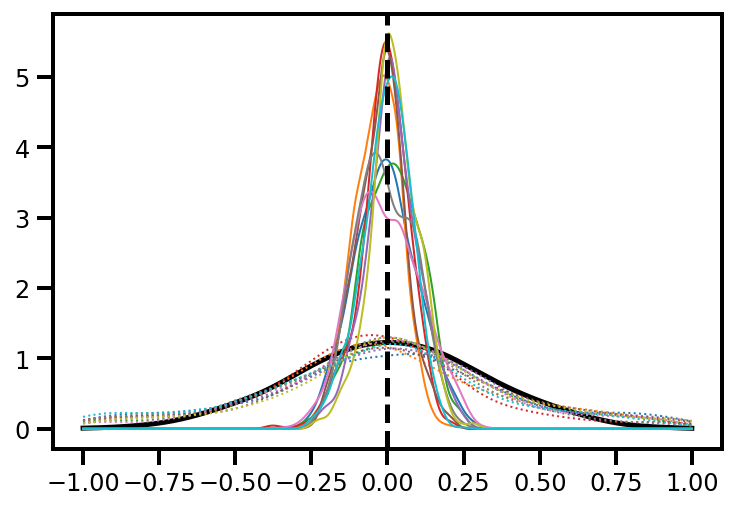

In [7]:
a = plot_1d_uncorrelated(ug10,-1,1,n)#,beta_idx=19) #By default these plots show the final beta

## 18 dims

In [8]:
n=18

In [9]:
warnings.filterwarnings('ignore') #ignore overflow warnings
ug18 = run_nfo(n=n,log_like=log_like_ucg,log_prior=log_flat_prior,top_verbose=False,
               beta_max=1.5 )

Inference mode is optimization. Maximum beta is: 1.5


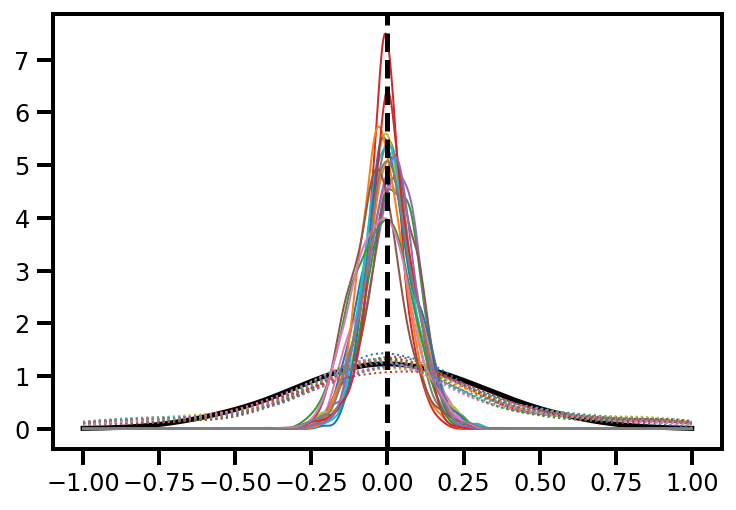

0

In [10]:
plot_1d_uncorrelated(ug18,-1.,1.,n)

# Double Gaussian test

## 3 dims
Notes:
- At $d=5$ we start to have issues with overflowing importance weights that seem to propagate into SINF
- Also while we recover the second peak for $d=2,3$, we lose it in $d=4,5,10$ with current settings. 
- In $d=3$ we lose it if we set $\beta_{\rm{max}}$ to 1 (no problems with 1.5).

In [31]:
n=3
def log_like_ducg(x ,w1=0.3,mu1=0.625 ,mu2=-0.325 ,sig_scale=1/10,sig_scale_12=1/2):
    n=x.shape[-1]
    w2=1-w1
    log_like1 = log_like_ucg(x,mu_diag=mu1,sig_scale=sig_scale*sig_scale_12) #make first narrower like before
    log_like2 = log_like_ucg(x,mu_diag=mu2,sig_scale=sig_scale)
    return  logsumexp(jnp.array([jnp.log(w1) + log_like1, jnp.log(w2) + log_like2]), axis=0)

In [42]:
warnings.filterwarnings('ignore') #ignore overflow warnings
dug3 = run_nfo(n=n,log_like=log_like_ducg,log_prior=log_flat_prior,top_verbose=False,
                beta_max=1.5,
                  low=-1.,high=1.
                 ,trainable_qw=True,sgd_steps=10 
                 )

Inference mode is optimization. Maximum beta is: 1.5


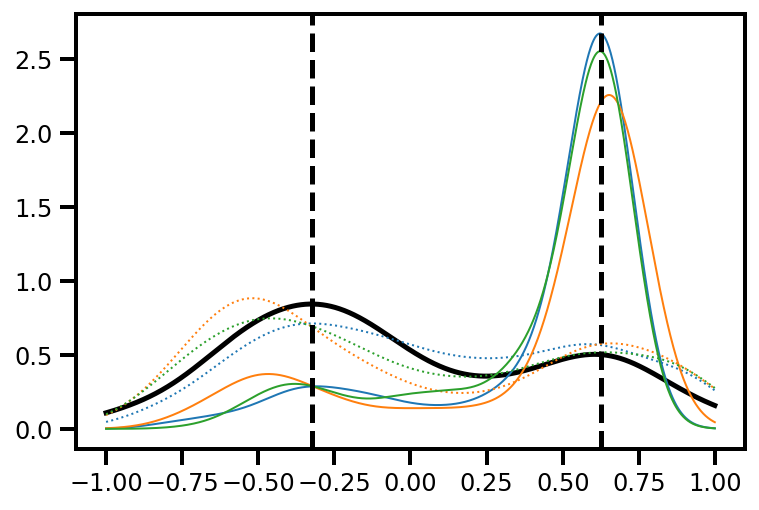

0

In [47]:
plot_1d_double(dug3,-1.,1.,n) #at lower beta this gets both peaks

## 10 dims


In [49]:
n=10
warnings.filterwarnings('ignore') #ignore overflow warnings
dug10 = run_nfo(n=n,log_like=log_like_ducg,log_prior=log_flat_prior,top_verbose=False,
                beta_max=1.5,
                  low=-1.,high=1.
#                  ,trainable_qw=True,sgd_steps=10 #sinf breaks here, asked Biwei
                 )

Inference mode is optimization. Maximum beta is: 1.5


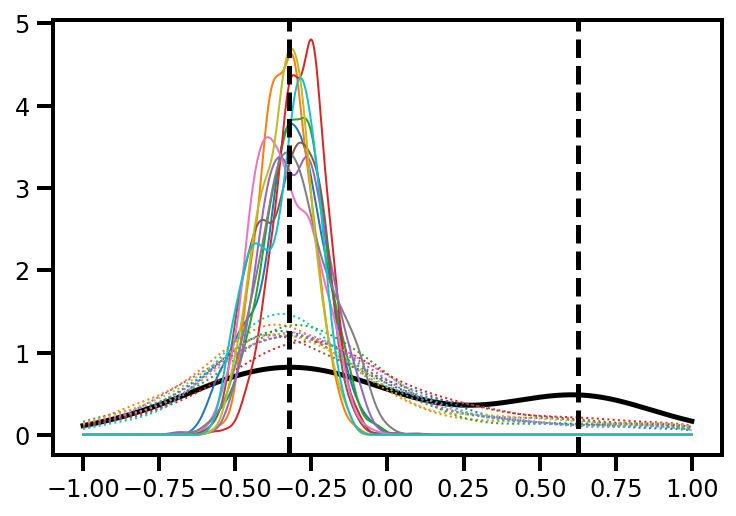

0

In [58]:
plot_1d_double(dug10,-1.,1.,n) #no second peak here...

# Correlated Gaussian test

## 5 dims

In [61]:
n = 5
# wishart draw from Richard's example
# lazily force this to give a certain condition number and choose scale by eye for some level of control...
def get_icov(n,target=200,iseed=seed,eps=1,scale=50):
    condition=0
    eigmax=np.inf
    this_seed=iseed
    while(abs(condition-target)>eps):
        wish = scipy.stats.wishart(df=n, scale=np.eye(n)* scale,seed=this_seed)
        iC = wish.rvs(size=1)
        C = np.linalg.inv(iC)
        eigs = np.linalg.eigvals(C)
        eigmax,eigmin = eigs.max(),eigs.min()
        condition = eigmax/eigmin
        this_seed+=1
    print("PSD: ",np.all(eigs>0))
    print("Condition number: ", condition)
    print("Op norm: ", eigmax)
    return iC,C

iCov,Cov=get_icov(n,eps=1)
def log_like_cg(x,mu_diag=0,icov=iCov):
    n=x.shape[-1]
    mu = mu_diag*jnp.ones(n)
    return -0.5 * jnp.log(2 * jnp.pi * 1/jnp.linalg.det(icov) ) - 0.5 * jnp.dot((x - mu),jnp.dot(icov,(x - mu)))


PSD:  True
Condition number:  199.54502688948327
Op norm:  0.33203908121598824


In [65]:
cg5 = run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=False,
                  beta_max=1.5,
                  low=-1.,high=1.,
                 )

Inference mode is optimization. Maximum beta is: 1.5


Migrate to getdist for corner-style plots quickly - we sacrifice the ability to see the details such as AF, latent draw, gradient etc, but these lose meaning in high-$d$ anyways

In [63]:
def plot_corr_gd(trace,Cov,Ngd=1000):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    names = ["x%s"%i for i in range(n)]
    labels =  ["x_%s"%i for i in range(n)]

    truth = n_mvn.rvs(mean=np.zeros(n),cov=Cov,size=Ngd)
    truth_gd = MCSamples(samples=truth,names = names, labels = labels, label='truth')

    qmax=qnums.max()
    s_w,s_uw = t2a(qmodels[0]['q{0}_w'.format(qmax)].sample(Ngd,device='cpu')[0]),t2a(qmodels[0]['q{0}_uw'.format(qmax)].sample(Ngd,device='cpu')[0])
    samples_w = MCSamples(samples=s_w,names = names, labels = labels, label='q_w')
    samples_uw = MCSamples(samples=s_uw,names = names, labels = labels, label='q_uw')

    # Triangle plot
    g = plots.get_subplot_plotter()
    g.triangle_plot([samples_uw,truth_gd,samples_w], filled=True)
    plt.show()

Removed no burn in
Removed no burn in
Removed no burn in


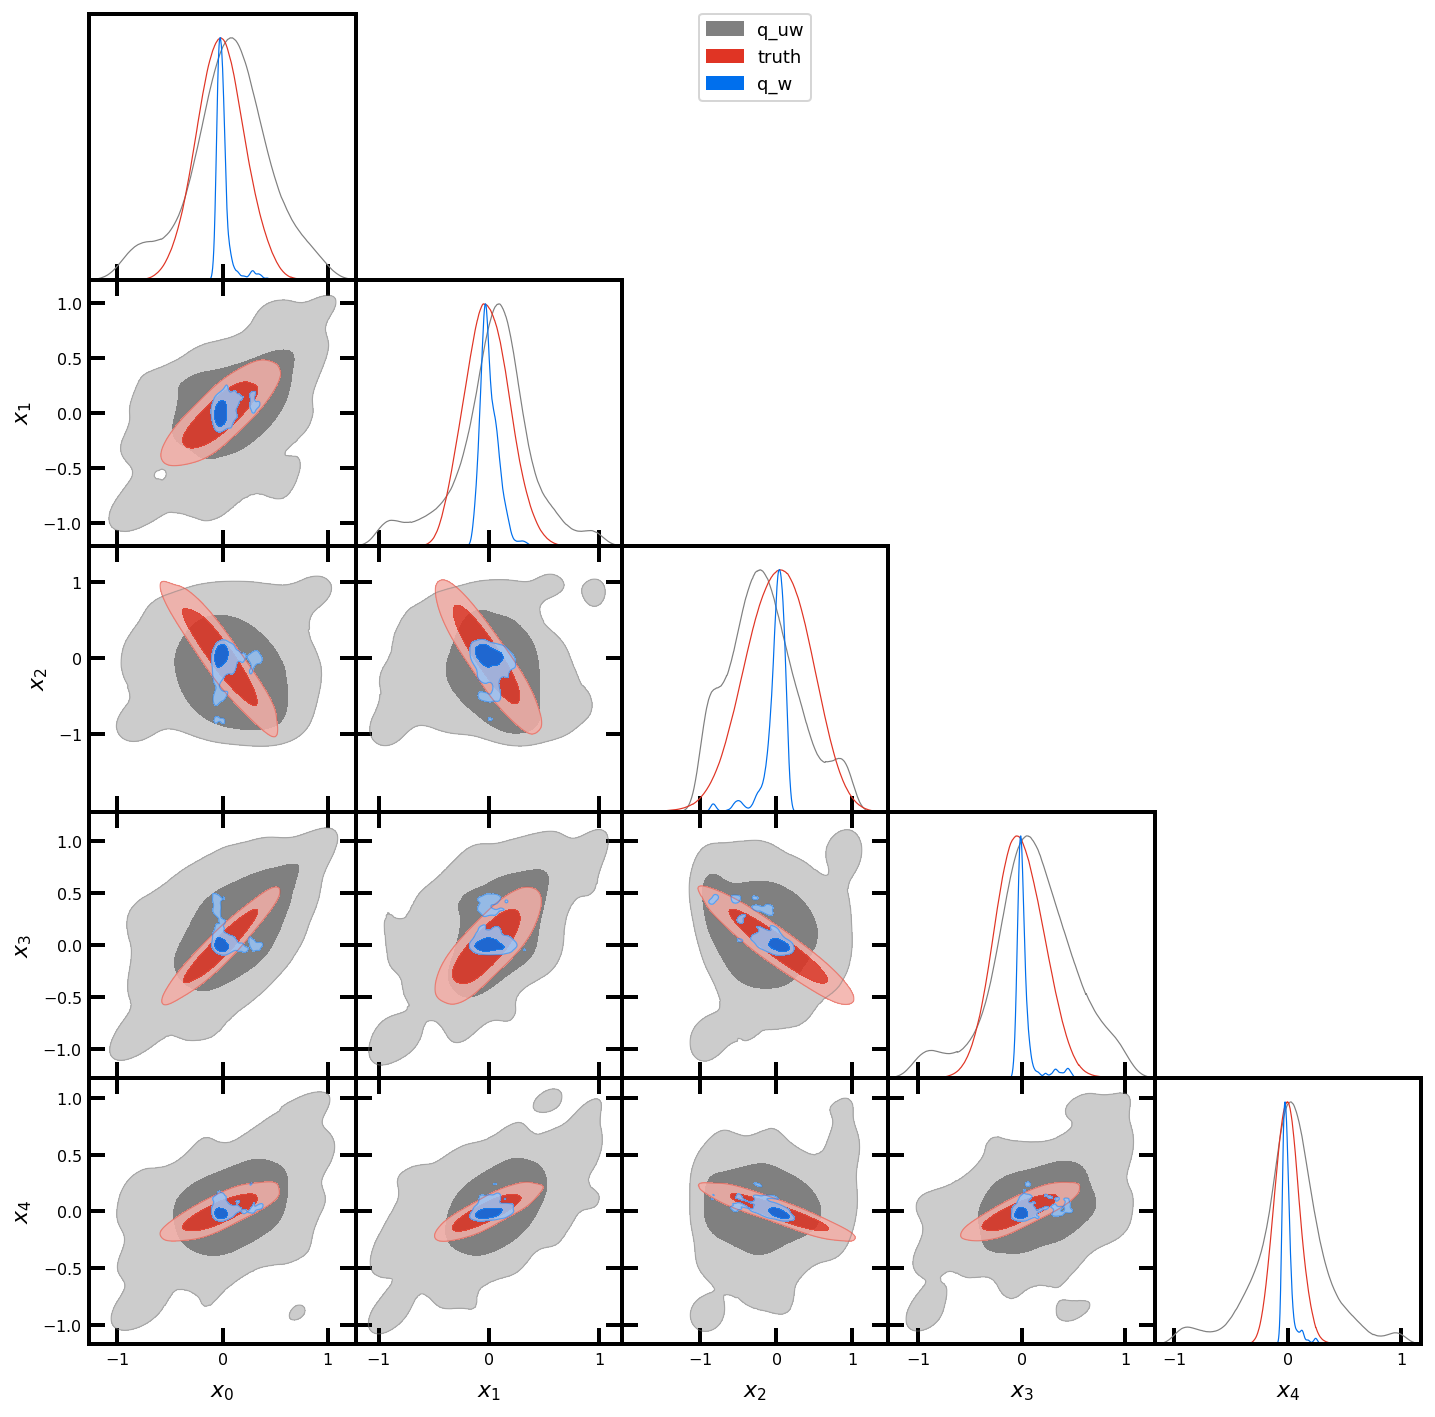

In [64]:
plot_corr_gd(cg5,Cov)

## 10 dims

In [76]:
n = 10
iCov,Cov=get_icov(n,eps=1,scale=25)
def log_like_cg(x,mu_diag=0,icov=iCov):
    n=x.shape[-1]
    mu = mu_diag*jnp.ones(n)
    return -0.5 * jnp.log(2 * jnp.pi * 1/jnp.linalg.det(icov) ) - 0.5 * jnp.dot((x - mu),jnp.dot(icov,(x - mu)))

PSD:  True
Condition number:  199.08320751596926
Op norm:  0.3175848066033764


In [85]:
cg10 = run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=False,
                  beta_max=1.5,rel_beta=.75,
                  use_latent_beta2=True, #this helps some in terms of fewer beta compared to drawing from q_w
                  low=-1.,high=1.,
                  #many beta steps~100
                 )

Inference mode is optimization. Maximum beta is: 1.5


Removed no burn in
Removed no burn in
Removed no burn in


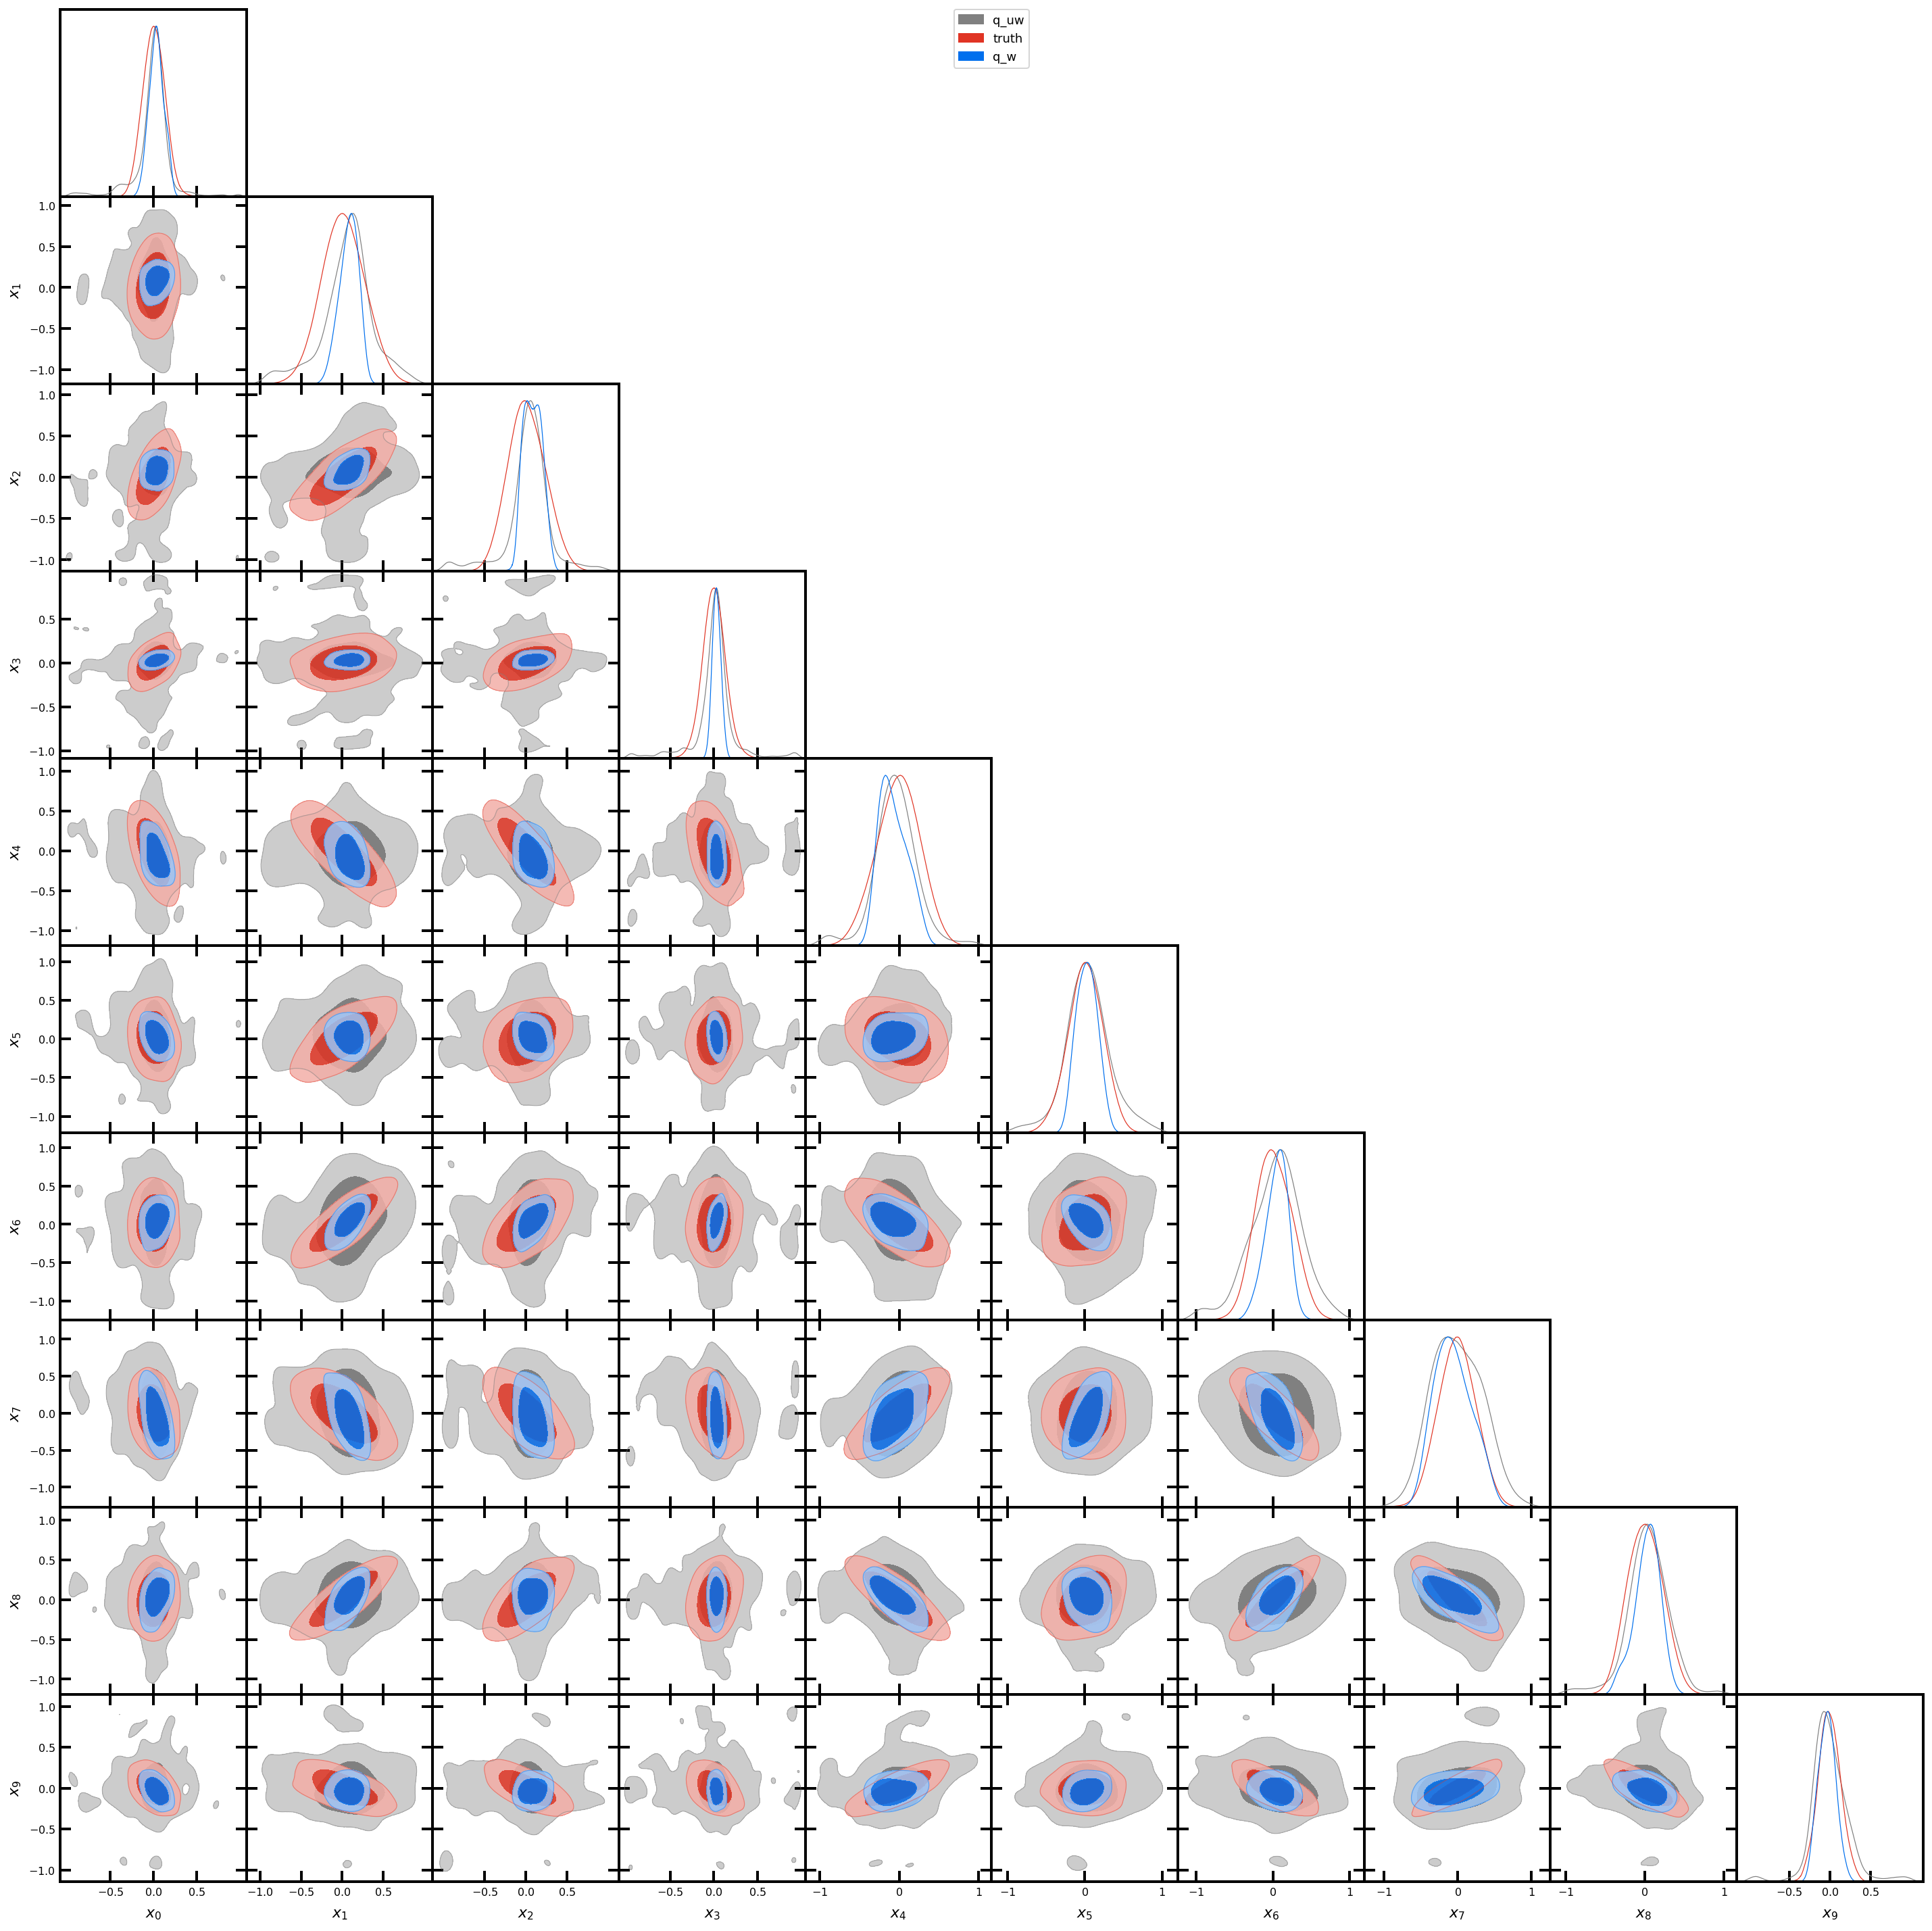

In [84]:
plot_corr_gd(cg10,Cov)